In [5]:
import pandas as pd
import numpy as np
import math
from matplotlib import pyplot as plt
from IPython.core.display import display, HTML
from pprint import pprint
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
# Utility functions
def abs_err(pred, real):
    return abs((pred - real) / real)

def err(pred, real):
    return (pred - real) / real

def gmae(x):
    return np.exp(np.log(abs(x)).mean())

def histogram(df, perc=True, bins=[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 1.5, 2.0, 3.0, 4.0]):
    count = len(df)
    ret = {}
    for idx, b in enumerate(bins):
        if idx == 0:
            continue
        ret[(bins[idx-1], bins[idx])] = 0
    for x in df:
        for idx, b in enumerate(bins):
            if idx == 0:
                continue
            if x >= bins[idx-1] and x < bins[idx]:
                ret[(bins[idx-1], bins[idx])] += 1
                break
    for b, c in sorted(ret.items(), key=lambda x: x[0]):
        if perc:
            print("{:.0f}% - {:.0f}%: {:.2f}%".format(b[0] * 100, b[1] * 100, c / count * 100))
        else:
            print("{:.2f} - {:.2f}: {:.2f}%".format(b[0], b[1], c / count * 100))
    return ret

def strip_unit(x):
    for col in ['dram_read_throughput', 'dram_write_throughput', 'gld_requested_throughput', 'gld_throughput',\
               'gst_requested_throughput', 'gst_throughput', 'l2_read_throughput', 'l2_write_throughput', \
                'shared_load_throughput', 'shared_store_throughput']:
        if col in x.keys():
            if x[col].endswith('GB/s'):
                x[col] = float(x[col].rstrip('GB/s'))
            elif x[col].endswith('MB/s'):
                x[col] = float(x[col].rstrip('MB/s')) / 1e3
            elif x[col].endswith('B/s'):
                x[col] = float(x[col].rstrip('B/s')) / 1e9
            else:
                raise Exception("Unrecognizable unit!")
    return x
    
def p2f(x):
    for col in ['flop_dp_efficiency', 'flop_sp_efficiency', 'gld_efficiency', 'gst_efficiency', \
                'shared_efficiency', 'sm_efficiency', 'warp_execution_efficiency']:
        if col in x.keys():
            x[col] = float(str(x[col]).rstrip('%')) / 100.0
    return x

def strip_parenthesis(x):
    for col in ['dram_utilization', 'l2_utilization', 'tex_utilization']:
        if col in x.keys():
            x[col] = x[col].strip('(').strip(')')
    return x

def process_smem(x):
    # To bytes
    if 'smem' in x.keys():
        if x['smem'].endswith('MB'):
            x['smem'] = int(float(x['smem'].rstrip('MB')) * 1024 * 1024)
        elif x['smem'].endswith('KB'):
            x['smem'] = int(float(x['smem'].rstrip('KB')) * 1024)
        elif x['smem'].endswith('B'):
            x['smem'] = int(x['smem'].rstrip('B'))
        else:
            raise Exception("Unrecognizable unit!")
    return x
        
def preprocessing(df):
    df = df.apply(func=p2f, axis=1)
    df = df.apply(func=strip_unit, axis=1)
    df = df.apply(func=strip_parenthesis, axis=1)
    df = df.apply(func=process_smem, axis=1)
    df = df[(df['kernel_name'] != 'gemv2T_kernel') & (df['kernel_name'] != 'splitKreduce_kernel')]
    return df

def div_round_up(x, y):
    return int((x + y - 1) / y)

### 1050 Ti

In [7]:
peak_throughput = 2809.313
peak_PCIe_BW = 5.9 # 16
peak_DRAM_BW = 100.675
peak_L2_BW = 692.587

### Tesla V100

In [3]:
peak_throughput = 15441.524
peak_PCIe_BW = 5.9 # 16
peak_DRAM_BW = 804.497
peak_L2_BW = 2847.457
peak_SMEM_BW = 3918.911
num_SM = 80
L2_size = 6 * 1024 * 1024
SMEM_size = 96 * 1024
regs_size = 64 * 1024 * 4
maximum_CTA_per_SM = 32
maximum_warps_per_SM = 64
frequency = 876 # MHz, for memory

### Concat

In [8]:
concat_data = pd.read_csv('./data/concat_1.csv', delimiter=',')
concat_data = preprocessing(concat_data)
concat_data.head()

kernel_name  batch_size   M  N    K  kernel_runtime  op_runtime  \
0  CatArrayBatchedCopy           1  64  1   15           3.168          45   
1  CatArrayBatchedCopy           1  64  1   64           2.784          45   
2  CatArrayBatchedCopy           1  64  1  197           3.264          44   
3  CatArrayBatchedCopy           1  64  1  256           3.680          47   
4  CatArrayBatchedCopy           1  64  1  512           4.243          47   

   achieved_occupancy  dram_read_throughput  dram_write_throughput  \
0            0.740514                0.3486                 0.4621   
1            0.671025                2.7621                 2.5203   
2            0.635279                3.2005                 4.7699   
3            0.635174                3.8698                 3.2970   
4            0.589177               11.5830                 8.4798   

   dram_read_transactions  dram_write_transactions dram_utilization  \
0                      32                       42                0   
1                     291                      265                1   
2                     416                      620                1   
3                     538                      459                1   
4                    2107                     1542                2   

   flop_count_dp  flop_count_dp_add  flop_count_dp_fma  flop_count_dp_mul  \
0              0                  0                  0                  0   
1              0                  0                  0                  0   
2              0                  0                  0                  0   
3              0                  0                  0                  0   
4              0                  0                  0                  0   

   flop_dp_efficiency  flop_count_sp  flop_count_sp_add  flop_count_sp_fma  \
0                 0.0              0                  0                  0   
1                 0.0              0                  0                  0   
2                 0.0              0                  0                  0   
3                 0.0              0                  0                  0   
4                 0.0              0                  0                  0   

   flop_count_sp_mul  flop_count_sp_special  flop_sp_efficiency  \
0                  0                   1950                 0.0   
1                  0                   8320                 0.0   
2                  0                  12682                 0.0   
3                  0                  12800                 0.0   
4                  0                  13312                 0.0   

   gld_efficiency  gld_requested_throughput  gld_throughput  gld_transactions  \
0          0.3264                    1.9568          5.9958              8586   
1          0.5438                    6.0031         11.0390             16546   
2          0.7336                   13.4490         18.3330             25258   
3          0.7779                   16.0040         20.5720             27266   
4          0.8694                   23.7010         27.2630             36098   

   gld_transactions_per_request  gst_efficiency  gst_requested_throughput  \
0                     18.000000          0.9990                    1.2865   
1                     21.377261          1.0000                    4.9315   
2                     21.350803          0.9998                   12.3140   
3                     20.909509          1.0000                   14.9410   
4                     19.618478          1.0000                   22.8660   

   gst_throughput  gst_transactions  gst_transactions_per_request  \
0          1.2878               122                      3.935484   
1          4.9315               520                      4.000000   
2         12.3170              1601                      3.992519   
3         14.9410              2080                      4.000000   
4         22.8660              4160                      4.00000

In [9]:
A_size = concat_data["batch_size"] * concat_data["M"] * concat_data["K"]
B_size = concat_data["batch_size"] * concat_data["N"] * concat_data["K"]
concat_traffic = 2 * (A_size + B_size) * 4
estimated_time = concat_traffic / peak_DRAM_BW / 1000
error = abs_err(estimated_time, concat_data['kernel_runtime'])
histogram(error)
print("GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(gmae(error) * 100.0, error.mean() * 100.0, error.std() * 100.0))

0% - 5%: 0.06%
5% - 10%: 27.91%
10% - 15%: 50.26%
15% - 20%: 10.09%
20% - 25%: 4.73%
25% - 30%: 1.98%
30% - 40%: 0.77%
40% - 50%: 0.89%
50% - 60%: 0.51%
60% - 80%: 1.85%
80% - 100%: 0.96%
100% - 150%: 0.00%
150% - 200%: 0.00%
200% - 300%: 0.00%
300% - 400%: 0.00%
GMAE: 12.66%, mean: 14.72%, std: 12.22%


In [ ]:
fig = plt.figure()
ax = plt.gca()
plt.scatter(concat_traffic, concat_data["dram_read_throughput"] + concat_data["dram_write_throughput"])
ax.set_xscale('log')

In [ ]:
actual_peak_DRAM_BW = max(concat_data["dram_read_throughput"] + concat_data["dram_write_throughput"])
actual_peak_DRAM_BW

In [ ]:
estimated_time = concat_traffic / actual_peak_DRAM_BW / 1000
error = abs_err(estimated_time, concat_data['kernel_runtime'])
histogram(error)
print("GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(gmae(error) * 100.0, error.mean() * 100.0, error.std() * 100.0))

### Memcpy

In [5]:
memcpy_data = pd.read_csv('./data/memcpy_1.csv', delimiter=',')
memcpy_data = preprocessing(memcpy_data)
memcpy_data.head()

kernel_name  batch_size   M     N  kernel_runtime  op_runtime  \
0  CUDA memcpy HtoD           1  64    64           2.305          26   
1  CUDA memcpy HtoD           1  64   128           4.022          30   
2  CUDA memcpy HtoD           1  64   256           8.075          35   
3  CUDA memcpy HtoD           1  64   512          21.385          51   
4  CUDA memcpy HtoD           1  64  1024          41.688          76   

   throughput  
0  6.2742GB/s  
1  7.3928GB/s  
2  7.5389GB/s  
3  5.5608GB/s  
4  5.7842GB/s

In [ ]:
memcpy_traffic = memcpy_data['batch_size'] * memcpy_data['M'] * memcpy_data['N'] * 4
estimated_time = memcpy_traffic / 5.9 / 1000 # Actual PCIe BW = 5.9 GB/s
error = abs_err(estimated_time, memcpy_data['kernel_runtime'])
histogram(error)
print("GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(gmae(error) * 100.0, error.mean() * 100.0, error.std() * 100.0))

### Embedding Lookup Forward

In [5]:
elf_data = pd.read_csv('./data/embedding_lookup_1_V100.csv', delimiter=',')
elf_data = preprocessing(elf_data)
elf_data.head()

kernel_name  batch_size  num_embeddings  num_tables  \
0  batched_embedding_forward_kernel_1         128            1000          32   
1  batched_embedding_forward_kernel_1         128            1000          32   
2  batched_embedding_forward_kernel_1         128            1000          32   
3  batched_embedding_forward_kernel_1         128            1000          32   
4  batched_embedding_forward_kernel_1         128            1000          32   

   bag_size  embedding_dim  rows_per_block  kernel_runtime  op_runtime  \
0         8             32             128           5.313          24   
1         8             32             128           5.332          20   
2         8             64              64           8.628          18   
3         8            128              32          22.220          24   
4         8            256              16          42.922          45   

   achieved_occupancy  dram_read_throughput  dram_write_throughput  \
0            0.447844                152.09                 45.796   
1            0.448276                183.87                 35.139   
2            0.448254                376.21                126.370   
3            0.701845                439.18                104.700   
4            0.864968                499.97                112.930   

   dram_read_transactions  dram_write_transactions dram_utilization  \
0                   45134                    13590                2   
1                   54806                    10474                3   
2                  169454                    56920                6   
3                  369140                    88000                7   
4                  769401                   173783                8   

   flop_count_dp  flop_count_dp_add  flop_count_dp_fma  flop_count_dp_mul  \
0              0                  0                  0                  0   
1              0                  0                  0                  0   
2              0                  0                  0                  0   
3              0                  0                  0                  0   
4              0                  0                  0                  0   

   flop_dp_efficiency  flop_count_sp  flop_count_sp_add  flop_count_sp_fma  \
0                 0.0      1048576.0          1048576.0                  0   
1                 0.0      1048576.0          1048576.0                  0   
2                 0.0      2097152.0          2097152.0                  0   
3                 0.0      4194304.0          4194304.0                  0   
4                 0.0      8388608.0          8388608.0                  0   

   flop_count_sp_mul  flop_count_sp_special  flop_sp_efficiency  \
0                  0                  32768              0.0071   
1                  0                  32768              0.0071   
2                  0                  65536              0.0102   
3                  0                 131072              0.0117   
4                  0                 262144              0.0129   

   gld_efficiency  gld_requested_throughput  gld_throughput  gld_transactions  \
0          0.1550                    73.111          471.95            140052   
1          0.1550                    72.787          469.81            140039   
2          0.1395                    84.779          607.74            273741   
3          0.1316                    84.671          643.25            540672   
4          0.1283                    89.831          700.01           1077248   

   gld_transactions_per_request  gst_efficiency  gst_requested_throughput  \
0                      9.897515             1.0                    55.210   
1                      9.896430             1.0                    54.966   
2                     10.194119             1.0                    72.749   
3                     11.000000             1.0                    77.970   
4                     11.434783        

In [6]:
def forward_time(B, E, T, L, D):
    table_offsets_t = 32
    offsets_t = 64
    indices_t = div_round_up(4 * L, 32) * 32
    weights_t = L * div_round_up(4 * D, 32) * 32
    output_t = div_round_up(4 * D, 32) * 32
    total_t = B * T * (table_offsets_t + offsets_t + indices_t + weights_t + output_t)
    return total_t / peak_DRAM_BW / 1000

elf_time_all = elf_data.apply(lambda x: forward_time(*x[1:6]), axis=1)
error_all = abs_err(elf_time_all, elf_data['kernel_runtime'])
histogram(error_all)
print("==== All sizes ====")
print("GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(gmae(error_all) * 100.0, error_all.mean() * 100.0, error_all.std() * 100.0))
elf_time_big = elf_data[elf_data['num_embeddings'] >= 100000].apply(lambda x: forward_time(*x[1:6]), axis=1)
error_big = abs_err(elf_time_big, elf_data[elf_data['num_embeddings'] >= 100000]['kernel_runtime'])
histogram(error_big)
print("==== Big sizes ====")
print("GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(gmae(error_big) * 100.0, error_big.mean() * 100.0, error_big.std() * 100.0))

0% - 5%: 24.14%
5% - 10%: 16.47%
10% - 15%: 10.63%
15% - 20%: 6.06%
20% - 25%: 3.59%
25% - 30%: 2.31%
30% - 40%: 5.64%
40% - 50%: 3.64%
50% - 60%: 2.43%
60% - 80%: 2.78%
80% - 100%: 2.17%
100% - 150%: 4.38%
150% - 200%: 4.50%
200% - 300%: 10.28%
300% - 400%: 0.98%
==== All sizes ====
GMAE: 16.77%, mean: 56.23%, std: 82.65%
0% - 5%: 43.09%
5% - 10%: 19.54%
10% - 15%: 13.51%
15% - 20%: 6.49%
20% - 25%: 2.86%
25% - 30%: 0.85%
30% - 40%: 8.57%
40% - 50%: 3.94%
50% - 60%: 0.93%
60% - 80%: 0.23%
80% - 100%: 0.00%
100% - 150%: 0.00%
150% - 200%: 0.00%
200% - 300%: 0.00%
300% - 400%: 0.00%
==== Big sizes ====
GMAE: 5.91%, mean: 11.54%, std: 12.67%


### Embedding Lookup Backward

In [7]:
elbs_data = pd.read_csv('./data/embedding_lookup_0_sgd_V100.csv', delimiter=',')
elbs_data = preprocessing(elbs_data)
elbs_data.head()

kernel_name  batch_size  num_embeddings  \
0  batched_embedding_backward_sgd_kernel_1         128            1000   
1  batched_embedding_backward_sgd_kernel_1         128            1000   
2  batched_embedding_backward_sgd_kernel_1         128            1000   
3  batched_embedding_backward_sgd_kernel_1         128            1000   
4  batched_embedding_backward_sgd_kernel_1         128            1000   

   num_tables  bag_size  embedding_dim  rows_per_block  kernel_runtime  \
0          32         8            128              32          38.795   
1          32         8            128              32          38.319   
2          32         8            256              16          77.345   
3          32        16            128              32          68.275   
4          32        16            256              16         138.590   

   op_runtime  achieved_occupancy  dram_read_throughput  \
0          41            0.743241                309.77   
1          40            0.748216                304.89   
2          79            0.871634                329.79   
3          70            0.773014                300.10   
4         140            0.913576                306.92   

   dram_write_throughput  dram_read_transactions  dram_write_transactions  \
0                 296.17                  419310                   400901   
1                 295.77                  422232                   409592   
2                 316.95                  868635                   834808   
3                 332.04                  714204                   790201   
4                 331.01                 1503188                  1621161   

  dram_utilization  flop_count_dp  flop_count_dp_add  flop_count_dp_fma  \
0                8              0                  0                  0   
1                8              0                  0                  0   
2                8              0                  0                  0   
3                8              0                  0                  0   
4                8              0                  0                  0   

   flop_count_dp_mul  flop_dp_efficiency  flop_count_sp  flop_count_sp_add  \
0                  0                 0.0      8388608.0                  0   
1                  0                 0.0      8388608.0                  0   
2                  0                 0.0     16777216.0                  0   
3                  0                 0.0     16777216.0                  0   
4                  0                 0.0     33554432.0                  0   

   flop_count_sp_fma  flop_count_sp_mul  flop_count_sp_special  \
0          4194304.0                  0                 131072   
1          4194304.0                  0                 131072   
2          8388608.0                  0                 262144   
3          8388608.0                  0                 131072   
4         16777216.0                  0                 262144   

   flop_sp_efficiency  gld_efficiency  gld_requested_throughput  \
0              0.0153          0.8742                    391.48   
1              0.0148          0.8742                    382.66   
2              0.0160          0.8737                    400.83   
3              0.0174          0.9328                    444.69   
4              0.0171          0.9325                    430.50   

   gld_throughput  gld_transactions  gld_transactions_per_request  \
0          447.84            606208                     11.384615   
1          437.74            606208                     11.384615   
2          458.76           1208320                     11.800000   
3          476.75           1134592                     13.190476   
4          461.65           2260992                     13.463415   

   gst_efficiency  gst_requested_throughput  gst_throughput  gst_transactions  \
0             1.0                    387.32          387.32            524288   
1             1.0         

In [10]:
def backward_time(B, E, T, L, D):
    table_offsets_t = 32
    offsets_t = 64
    indices_t = div_round_up(4 * L, 32) * 32
    weights_t = div_round_up(2 * 4 * L * D, 32) * 32
    output_t = div_round_up(4 * D, 32) * 32
    total_t = B * T * (table_offsets_t + offsets_t + indices_t + weights_t + output_t)
    return total_t / peak_DRAM_BW / 1000

elbs_time_all = elbs_data.apply(lambda x: backward_time(*x[1:6]), axis=1)
error_all = abs_err(elbs_time_all, elbs_data['kernel_runtime'])
histogram(error_all)
print("==== All sizes ====")
print("GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(gmae(error_all) * 100.0, error_all.mean() * 100.0, error_all.std() * 100.0))
elbs_time_big = elbs_data[elf_data['num_embeddings'] >= 100000].apply(lambda x: backward_time(*x[1:6]), axis=1)
error_big = abs_err(elbs_time_big, elbs_data[elf_data['num_embeddings'] >= 100000]['kernel_runtime'])
histogram(error_big)
print("==== Big sizes ====")
print("GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(gmae(error_big) * 100.0, error_big.mean() * 100.0, error_big.std() * 100.0))

0% - 5%: 39.30%
5% - 10%: 19.75%
10% - 15%: 3.34%
15% - 20%: 4.11%
20% - 25%: 2.57%
25% - 30%: 2.04%
30% - 40%: 2.78%
40% - 50%: 1.79%
50% - 60%: 2.53%
60% - 80%: 2.99%
80% - 100%: 2.07%
100% - 150%: 1.97%
150% - 200%: 3.66%
200% - 300%: 11.11%
300% - 400%: 0.00%
==== All sizes ====
GMAE: 10.67%, mean: 48.51%, std: 81.84%
0% - 5%: 66.51%
5% - 10%: 26.26%
10% - 15%: 2.52%
15% - 20%: 1.42%
20% - 25%: 0.00%
25% - 30%: 0.00%
30% - 40%: 1.42%
40% - 50%: 0.00%
50% - 60%: 0.00%
60% - 80%: 0.00%
80% - 100%: 0.00%
100% - 150%: 0.16%
150% - 200%: 0.47%
200% - 300%: 1.26%
300% - 400%: 0.00%
==== Big sizes ====
GMAE: 3.30%, mean: 8.44%, std: 28.12%


/home/zhongyilin/miniconda3/envs/myself/lib/python3.7/site-packages/ipykernel_launcher.py:15: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  from ipykernel import kernelapp as app
/home/zhongyilin/miniconda3/envs/myself/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


### Fully Connected

In [40]:
fc_data = pd.read_csv('./data/fully_connected_1_V100.csv', delimiter=',')
fc_data = preprocessing(fc_data)
fc_data = fc_data[~(fc_data['kernel_name'].isin(['gemv2T_kernel_val', 'splitKreduce_kernel', 'reduce_1Block_kernel', 'dot_kernel']))]
trunc = fc_data[['kernel_name', 'batch_size', 'M', 'N', 'K', 'kernel_runtime', 'block_x', 'block_y', 'block_z', 'thread_x', 'thread_y', 'thread_z', 'regs', 'smem']]
bmm_data = fc_data[(fc_data['batch_size'] > 1)]
addmm_data = fc_data[(fc_data['batch_size'] == 1)]
mkn = fc_data.sort_values(by=['batch_size', 'M', 'K', 'N'])
anchors = fc_data[(fc_data['M'] % 32 == 0) & (fc_data['N'] % 32 == 0)]
fc_data

kernel_name  batch_size      M    N      K  \
4      volta_sgemm_32x32_sliced1x4_tn           1     64    1    512   
8      volta_sgemm_32x32_sliced1x4_tn           1     64    1   3482   
9      volta_sgemm_32x32_sliced1x4_tn           1     64    1   4096   
12              volta_sgemm_128x32_tn           1     64   16     15   
13     volta_sgemm_32x32_sliced1x4_tn           1     64   16     64   
14     volta_sgemm_32x32_sliced1x4_tn           1     64   16    197   
15     volta_sgemm_32x32_sliced1x4_tn           1     64   16    256   
16     volta_sgemm_32x32_sliced1x4_tn           1     64   16    512   
17     volta_sgemm_32x32_sliced1x4_tn           1     64   16   1024   
18     volta_sgemm_32x32_sliced1x4_tn           1     64   16   1281   
19     volta_sgemm_32x32_sliced1x4_tn           1     64   16   2048   
20     volta_sgemm_32x32_sliced1x4_tn           1     64   16   3482   
21     volta_sgemm_32x32_sliced1x4_tn           1     64   16   4096   
22     volta_sgemm_32x32_sliced1x4_tn           1     64   16  32768   
23              volta_sgemm_128x32_tn           1     64   64     15   
24     volta_sgemm_32x32_sliced1x4_tn           1     64   64     64   
25     volta_sgemm_32x32_sliced1x4_tn           1     64   64    197   
26     volta_sgemm_32x32_sliced1x4_tn           1     64   64    256   
27     volta_sgemm_32x32_sliced1x4_tn           1     64   64    512   
28     volta_sgemm_32x32_sliced1x4_tn           1     64   64   1024   
29     volta_sgemm_32x32_sliced1x4_tn           1     64   64   1281   
30     volta_sgemm_32x32_sliced1x4_tn           1     64   64   2048   
31     volta_sgemm_32x32_sliced1x4_tn           1     64   64   3482   
32     volta_sgemm_32x32_sliced1x4_tn           1     64   64   4096   
33     volta_sgemm_32x32_sliced1x4_tn           1     64   64  32768   
34              volta_sgemm_128x32_tn           1     64  198     15   
35              volta_sgemm_128x32_tn           1     64  198     64   
36     volta_sgemm_32x32_sliced1x4_tn           1     64  198    197   
37     volta_sgemm_32x32_sliced1x4_tn           1     64  198    256   
38     volta_sgemm_32x32_sliced1x4_tn           1     64  198    512   
39     volta_sgemm_32x32_sliced1x4_tn           1     64  198   1024   
40     volta_sgemm_32x32_sliced1x4_tn           1     64  198   1281   
41     volta_sgemm_32x32_sliced1x4_tn           1     64  198   2048   
42     volta_sgemm_32x32_sliced1x4_tn           1     64  198   3482   
43     volta_sgemm_32x32_sliced1x4_tn           1     64  198   4096   
44     volta_sgemm_32x32_sliced1x4_tn           1     64  198  32768   
45              volta_sgemm_128x32_tn           1     64  225     15   
46              volta_sgemm_128x32_tn           1     64  225     64   
47     volta_sgemm_32x32_sliced1x4_tn           1     64  225    197   
48     volta_sgemm_32x32_sliced1x4_tn           1     64  225    256   
49     volta_sgemm_32x32_sliced1x4_tn           1     64  225    512   
50     volta_sgemm_32x32_sliced1x4_tn           1     64  225   1024   
51     volta_sgemm_32x32_sliced1x4_tn           1     64  225   1281   
52     volta_sgemm_32x32_sliced1x4_tn           1     64  225   2048   
53     volta_sgemm_32x32_sliced1x4_tn           1     64  225   3482   
54     volta_sgemm_32x32_sliced1x4_tn           1     64  225   4096   
55     volta_sgemm_32x32_sliced1x4_tn           1     64  225  32768   
56              volta_sgemm_128x32_tn           1     64  256     15   
57     volta_sgemm_32x32_sliced1x4_tn           1     64  256     64   
58     volta_sgemm_32x32_sliced1x4_tn           1     64  256    197   
59     volta_sgemm_32x32_sliced1x4_tn           1     64  256    256   
60     volta_sgemm_32x32_sliced1x4_tn           1     64  256    512   
61     volta_sgemm_32x32_sliced1x4_tn           1     64  256   1024   
62     volta_sgemm_32x32_sliced1x4_tn           1     64  256   1281   
63     volta_sgemm_32x32_sliced1x4_tn           1     64  256   20

#### Exporation

In [14]:
trunc['kernel_name'].unique()

array(['sgemm_32x32x32_NT', 'sgemm_32x32x32_NT_vec',
       'maxwell_sgemm_128x64_tn', 'maxwell_sgemm_128x128_tn',
       'sgemm_128x128x8_NT', 'sgemm_128x128x8_NT_vec',
       'maxwell_sgemm_32x128_tn'], dtype=object)

In [15]:
trunc['thread_x'].value_counts()

128    802
256    644
Name: thread_x, dtype: int64

In [108]:
# Compare runtime calculated by DRAM traffic with actual runtime
# ==> DRAM itself doesn't dominate in most of the cases.
e = err(((fc_data['dram_read_transactions'] + fc_data['dram_write_transactions']) * 32) / peak_DRAM_BW / 1000, fc_data['kernel_runtime'])
his = histogram(e, bins=[-1.5, -1.0, -0.95, -0.9, -0.8, -0.6, -0.5, -0.4, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05])

-150% - -100%: 0.00%
-100% - -95%: 10.00%
-95% - -90%: 2.14%
-90% - -80%: 10.00%
-80% - -60%: 38.21%
-60% - -50%: 17.50%
-50% - -40%: 10.89%
-40% - -30%: 3.21%
-30% - -25%: 1.79%
-25% - -20%: 0.71%
-20% - -15%: 1.07%
-15% - -10%: 1.43%
-10% - -5%: 1.96%
-5% - 0%: 1.07%
0% - 5%: 0.00%


In [51]:
# Compare runtime calculated by DRAM traffic with actual runtime
# ==> Compute doesn't dominate at all.
e = err((fc_data['flop_count_sp_fma']) / peak_throughput / 1000, fc_data['kernel_runtime'])
his = histogram(e, bins=[-1.5, -1.0, -0.95, -0.9, -0.8, -0.6, -0.5, -0.4, -0.3])

-150% - -100%: 0.00%
-100% - -95%: 7.65%
-95% - -90%: 4.86%
-90% - -80%: 15.91%
-80% - -60%: 32.18%
-60% - -50%: 39.40%
-50% - -40%: 0.00%
-40% - -30%: 0.00%


In [107]:
# Compare runtime calculated by DRAM traffic with actual runtime
# ==> Global transactions doesn't dominate either.
e = err(((fc_data['gld_transactions']) * 32) / peak_DRAM_BW / 1000, fc_data['kernel_runtime'])
his = histogram(e, bins=[-1.5, -1.0, -0.95, -0.9, -0.8, -0.6, -0.5, -0.4, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9, 0.95, 1.0, 1.5, 2.0])

-150% - -100%: 0.00%
-100% - -95%: 0.67%
-95% - -90%: 1.46%
-90% - -80%: 1.52%
-80% - -60%: 3.70%
-60% - -50%: 2.25%
-50% - -40%: 4.49%
-40% - -30%: 7.47%
-30% - -25%: 3.95%
-25% - -20%: 4.43%
-20% - -15%: 2.91%
-15% - -10%: 3.58%
-10% - -5%: 3.22%
-5% - 0%: 3.22%
0% - 5%: 2.98%
5% - 10%: 3.16%
10% - 15%: 3.83%
15% - 20%: 3.95%
20% - 25%: 3.34%
25% - 30%: 5.22%
30% - 40%: 6.98%
40% - 50%: 6.01%
50% - 60%: 1.94%
60% - 80%: 3.28%
80% - 90%: 2.13%
90% - 95%: 1.09%
95% - 100%: 1.09%
100% - 150%: 7.71%
150% - 200%: 3.76%


In [18]:
# unique_N = mkn['N'].unique()
# for N in unique_N:
#     plt.figure(figsize=(8,6))
#     plt.plot(range(len(mkn[mkn['N'] == N])), mkn[mkn['N'] == N]['kernel_runtime'])

In [19]:
# t = max(t_Mem, t_MemLatency, t_Compute)
# num_main_loop_iteration = K / blkK


# t_Mem = t_Prologue + (t_MainLoop_Mem + t_Epilogue) * (# CTA per SM)
#     t_Prologue = (t_DRAM_2_Regs_output) + (t_Regs_2_SMEM_output + t_SMEM_2_Regs_input) [t_GLS + t_SAS]
#         t_DRAM_2_Regs_output = LAT_DRAM + (blkM * blkN) / (BW_DRAM / # SM) --------------- [TBD]
#             LAT_DRAM --------------------------------- Look up the datasheet. [Good]
# 
#         t_Regs_2_SMEM_output = LAT_SMEM + (blkM * blkN) / (BW_SMEM) ---------------------- [TBD]
#             LAT_SMEM --------------------------------- Look up the datasheet. [Good]
# 
#         t_SMEM_2_Regs_input = (blkWM + blkWN) * blkK * (# warps) / (BW_SMEM)
#             blkWM,WN --------------------------------- [TBD]
#             (# warps) -------------------------------- [TBD]
# 
#         (# CTA) -------------------------------------- Calculated
# 
#     t_Epilogue = (blkM * blkN) / BW_DRAM ------------------------------------------------- [Good]
#     t_MainLoop_Mem = max(trf_L1, trf_L2, trf_DRAM) * num_main_loop_iteration --------------[Good]
#         trf_L1,L2,DRAM ------------------------------- Calculated [TODO]


# t_DRAM_LAT = t_Prologue + (tGLS + max(t_CS / blkK, t_SAS / blkK) * num_main_loop_iteration + t_Epilogue) * (# CTA per SM) / (# Active CTA)
#     t_Prologue: [same as above]
#     t_CS = (blkM * blkN * blkK) / BW_MAC
#     t_SAS = (LAT_SMEM + (blkM * blkN) + (blkWM + blkWN) * blkK * (# warps)) / (BW_SMEM)
#     t_Epilouge: [same as above]

# t_Compute_or_SMEM = t_Prologue + (t_MainLoop_Compute + t_Epilogue) * (# CTA per SM)
#     t_Prologue: [same as above]
#     t_MainLoop_Compute = max(t_CS, t_SAS) * num_main_loop_iteration
#         t_CS: [same as above]
#         t_SAS: [same as above]
#     t_Epilouge: [same as above]


# blkM,N,K --------------------------------------------- Predicted from shape [TODO]
# (# SM) ----------------------------------------------- Given
# BW_L1/L2/DRAM/MAC ------------------------------------ Measured
# (# CTA per SM) = (# CTA / # SM) ---------------------- [Good]
# (# Active CTA per SM) -------------------------------- Predicted from kernel names and shapes [TODO]

In [53]:
# Decision tree
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
clf = tree.DecisionTreeClassifier()
lb = LabelEncoder()

name_and_size = fc_data[(fc_data['kernel_name'] != 'gemv2T_kernel') & (fc_data['kernel_name'] != 'splitKreduce_kernel')][['batch_size', 'M', 'N', 'K', 'kernel_name']]
name_and_size["kernel_name_code"] = lb.fit_transform(name_and_size["kernel_name"])
X = name_and_size[['batch_size', 'M', 'N', 'K']]
y = name_and_size['kernel_name_code']
clf = clf.fit(X, y)
# plt.figure(figsize=(12, 8))
# tree.plot_tree(clf)
# plt.show()

def predict_kernel_name(*shape):
    n = clf.predict([*shape])
    return list(lb.inverse_transform(n))[0]
predict_kernel_name([1, 64, 64, 4096])

'volta_sgemm_32x32_sliced1x4_tn'

In [106]:
from sklearn.neural_network import MLPRegressor
rg = MLPRegressor(hidden_layer_sizes=(160,320,640,160), activation='relu', solver='lbfgs', max_iter=1000000)
X = fc_data[['batch_size', 'M', 'N', 'K']]
y = fc_data['kernel_runtime']
rg = rg.fit(X, y)

pred = rg.predict(fc_data[['batch_size', 'M', 'N', 'K']])
e = err(pred, fc_data['kernel_runtime'])
his = histogram(e, bins=[-100.0, -10.0, -2.0, -1.0, -0.95, -0.9, -0.8, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 2.0, 10.0, 100.0, 1000.0])

-10000% - -1000%: 10.20%
-1000% - -200%: 5.95%
-200% - -100%: 2.43%
-100% - -95%: 0.18%
-95% - -90%: 0.12%
-90% - -80%: 0.49%
-80% - -60%: 0.85%
-60% - -50%: 0.73%
-50% - -40%: 1.28%
-40% - -30%: 2.25%
-30% - -20%: 3.46%
-20% - -10%: 4.13%
-10% - 0%: 4.31%
0% - 10%: 4.19%
10% - 20%: 2.73%
20% - 30%: 3.16%
30% - 40%: 2.91%
40% - 50%: 1.82%
50% - 60%: 1.46%
60% - 80%: 1.94%
80% - 100%: 2.13%
100% - 200%: 7.16%
200% - 1000%: 19.85%
1000% - 10000%: 9.35%
10000% - 100000%: 0.49%


In [54]:
def get_blkMNK_from_kernel_name(kernel_name):
    splitted = kernel_name.split('_')
    x = splitted[2]
    blkN = int(x.split('x')[0])
    blkM = int(x.split('x')[1])
    # blkK is either 4 or 8. Assuming 4 for (<= 64) and 8 for others. No evidence. TODO: Confirm this.
    if blkM <= 64:
        blkK = 4
    else:
        blkK = 8
    return blkM, blkN, blkK

# batch_size, M, N, K = 1, 64, 64, 4096
# Assuming blkM,N,K are known. Find someone to confirm.
# A potential idea: use B, M, N, K to predict the kernel to be used.
def get_blks(batch_size, M, N, K, clf=None):
    if clf is None:
        row = trunc[(trunc['batch_size'] == batch_size) & (trunc['M'] == M) & (trunc['N'] == N) & (trunc['K'] == K)]
        if row.empty:
            return -1, -1, -1, -1, -1, -1
        kernel_name = str(row['kernel_name'])
    else:
        kernel_name = list(lb.inverse_transform(clf.predict([[batch_size, M, N, K]])))[0]
    blkM, blkN, blkK = get_blkMNK_from_kernel_name(kernel_name)
        
    # Confirmed
    block_x = div_round_up(N, blkN)
    block_y = div_round_up(M, blkM)
    
    # # Using batch_size as block_z for now. Usually works for BMM.
    # block_z = batch_size if batch_size > 1 else int(row['block_z'])
    block_z = batch_size

    return blkM, blkN, blkK, block_x, block_y, block_z

# Verify blkMNK and block_xyz correctness. TODO: Need a test set for prediction of blkM and blkN.
predicted_blks = bmm_data.apply(lambda x: get_blks(x['batch_size'], x['M'], x['N'], x['K'], clf), axis=1)
predicted_blks = pd.DataFrame(predicted_blks.tolist(), index=predicted_blks.index, columns =['blkM', 'blkN', 'blkK', 'block_x', 'block_y', 'block_z'])
actual_blkMNK = bmm_data.apply(lambda x: get_blkMNK_from_kernel_name(x['kernel_name']), axis=1)
actual_blkMNK = pd.DataFrame(actual_blkMNK.tolist(), index=actual_blkMNK.index, columns =['blkM', 'blkN', 'blkK'])

block_x_error = sum(predicted_blks['block_x'] != bmm_data['block_x']) / len(predicted_blks) * 100.0
block_y_error = sum(predicted_blks['block_y'] != bmm_data['block_y']) / len(predicted_blks) * 100.0
block_z_error = sum(predicted_blks['block_z'] != bmm_data['block_z']) / len(predicted_blks) * 100.0

blkM_error = sum(predicted_blks['blkM'] != actual_blkMNK['blkM']) / len(predicted_blks) * 100.0
blkN_error = sum(predicted_blks['blkN'] != actual_blkMNK['blkN']) / len(predicted_blks) * 100.0
blkK_error = sum(predicted_blks['blkK'] != actual_blkMNK['blkK']) / len(predicted_blks) * 100.0

print("Block xyz error rates: {}%, {}%, {}%".format(block_x_error, block_y_error, block_z_error))
print("blk xyz error rates: {}%, {}%, {}%".format(blkM_error, blkN_error, blkK_error))

Block xyz error rates: 0.0%, 0.0%, 0.0%
blk xyz error rates: 0.0%, 0.0%, 0.0%


In [28]:
# kernels and regs/smem usages are mapped one by one
# Occupancy (CTA per SM): warps per SM, blocks per SM, regs per SM, SMEM per SM
# bmm: only 128x64 and 128x128 kernels
# addmm: includes all others

info = {}
# for kernel in fc_data['kernel_name'].unique():
#     print(kernel)
#     df = fc_data[fc_data['kernel_name'] == kernel]
#     print('df length:', len(df))
#     print(df['thread_x'].unique(), df['regs'].unique(), df['smem'].unique())
# print("************")

for kernel in fc_data['kernel_name'].unique():
    df = fc_data[fc_data['kernel_name'] == kernel]
    num_thread_x = int(df['thread_x'].unique()[0])
    num_warps_per_CTA = num_thread_x // 32
    num_regs_per_thread = int(df['regs'].unique()[0])
    SMEM_per_CTA = int(df['smem'].unique()[0])
    blkM, blkN, _ = get_blkMNK_from_kernel_name(kernel)
    tmp = num_warps_per_CTA
    if kernel.endswith('sliced1x4_tn'):
        tmp = tmp // 4
    blkWM, blkWN = blkM, blkN
    while tmp > 1:
        if blkWM > blkWN:
            blkWM = blkWM // 2
        else:
            blkWN = blkWN // 2
        tmp = tmp // 2
    tmp = {}
    tmp['num_warps_per_CTA'] = num_warps_per_CTA
    tmp['num_active_CTA'] = min(maximum_warps_per_SM // num_warps_per_CTA, maximum_CTA_per_SM, regs_size // (num_thread_x * num_regs_per_thread), SMEM_size // SMEM_per_CTA)
    tmp['blkWM'] = blkWM
    tmp['blkWN'] = blkWN
    info[kernel] = tmp

#     print(kernel)
#     occ = df['achieved_occupancy']
#     histogram(occ / (tmp['num_active_CTA'] / maximum_CTA_per_SM), perc=False, bins=[0.0, 0.5, 0.8, 0.9, 1.0, 1.1, 1.2, 1.5, 2.0])
#     print(len(occ))

# occ = fc_data['achieved_occupancy']
# num_active_CTA_df = fc_data['kernel_name'].map(lambda x: info[x]['num_active_CTA'])
# histogram(occ / (num_active_CTA_df / maximum_CTA_per_SM), perc=False, bins=[0.0, 0.5, 0.8, 0.9, 1.0, 1.1, 1.2, 1.5, 2.0])
# print(len(occ))
    
pprint(info)

{'volta_sgemm_128x128_tn': {'blkWM': 64,
                            'blkWN': 32,
                            'num_active_CTA': 5,
                            'num_warps_per_CTA': 8},
 'volta_sgemm_128x32_sliced1x4_tn': {'blkWM': 32,
                                     'blkWN': 64,
                                     'num_active_CTA': 2,
                                     'num_warps_per_CTA': 8},
 'volta_sgemm_128x32_tn': {'blkWM': 32,
                           'blkWN': 16,
                           'num_active_CTA': 6,
                           'num_warps_per_CTA': 8},
 'volta_sgemm_128x64_tn': {'blkWM': 64,
                           'blkWN': 32,
                           'num_active_CTA': 7,
                           'num_warps_per_CTA': 4},
 'volta_sgemm_32x128_tn': {'blkWM': 32,
                           'blkWN': 16,
                           'num_active_CTA': 6,
                           'num_warps_per_CTA': 8},
 'volta_sgemm_32x32_sliced1x4_tn': {'blkWM': 32,
       

In [63]:
# L2 traffic: almost never bound on this. Set to 0. Evidence: L2 utilization has never been higher than 2.
L2_traffic = 0

def get_DRAM_traffic(batch_size, M, N, K, blkM, blkN, num_CTA, num_active_CTA):
    # Num of waves
    num_waves = div_round_up(num_CTA // batch_size, num_SM * num_active_CTA) # Num of CTA waves per batch

    A = M * K * 4
    B = N * K * 4

    num_block_per_A_col = div_round_up(M, blkM) # Num of CTA block in a block column of A
    num_block_per_B_row = div_round_up(N, blkN) # Num of CTA block in a block row of B

    # Possibility 1: Along rows
    if num_SM * num_active_CTA < num_block_per_B_row:
        DRAM_traffic_row = (B * num_block_per_A_col + A + blkM * num_waves * K * 4)
    else:
        DRAM_traffic_row = (B * num_waves + A + blkM * num_waves * K * 4)

    # Possibility 2: Along columns
    if num_SM * num_active_CTA < num_block_per_A_col: # One CTA batch doesn't fill a full column of A
        DRAM_traffic_col = (A * num_block_per_B_row + B + blkN * num_waves * K * 4)
    else:
        DRAM_traffic_col = (A * num_waves + B + blkN * num_waves * K * 4)

    # Take the min of them
    DRAM_traffic = batch_size * min(DRAM_traffic_row, DRAM_traffic_col)

    return DRAM_traffic
# get_DRAM_traffic(batch_size=1, M=64, N=64, K=4096, blkM=blkM, blkN=blkN, num_CTA=4)
# dram_trf = get_DRAM_traffic(batch_size=512, M=1024, N=512, K=4096, blkM=64, blkN=128, num_CTA=32768)
# df = bmm_data[(bmm_data['batch_size'] == 512) & (bmm_data['M'] == 1024) & (bmm_data['N'] == 512) & (bmm_data['K'] == 4096)]
# print(dram_trf / float(df['dram_read_transactions']))

In [125]:
def estimate_runtime(batch_size, M, N, K, clf=None, use_th_peak=True):
    kernel_name = predict_kernel_name([batch_size, M, N, K])
    blkM, blkN, blkK, block_x, block_y, block_z = get_blks(batch_size, M, N, K, clf=clf) # TODO: fix block_z for batch_size = 1
    blkWM, blkWN = info[kernel_name]['blkWM'], info[kernel_name]['blkWN']
    num_CTA = block_x * block_y * block_z
    throughput = peak_throughput if use_th_peak else corrected_peak_throughput
    num_main_loop_iteration = div_round_up(num_CTA, num_SM)
    num_warps = info[kernel_name]['num_warps_per_CTA']
    num_active_CTA = info[kernel_name]['num_active_CTA']
    DRAM_traffic = get_DRAM_traffic(batch_size, M, N, K, blkM, blkN, num_CTA, num_active_CTA) # Total

    LAT_DRAM = 1029 / frequency # See https://arxiv.org/pdf/1804.06826.pdf page 20
    LAT_SMEM = 19 / frequency # See https://arxiv.org/pdf/1804.06826.pdf page 19
#     t_DRAM_2_Regs_output = LAT_DRAM + (DRAM_traffic / (block_x * block_y * block_z)) * 4 / (peak_DRAM_BW / num_SM) / 1000
#     t_Regs_2_SMEM_output = LAT_SMEM + (blkM * blkN) * 4 / (peak_SMEM_BW) / 1000 # Good
#     t_SMEM_2_Regs_input = (blkWM + blkWN) * blkK * 4 * (num_warps) / peak_SMEM_BW / 1000 # Good

#     t_GLS = t_DRAM_2_Regs_output + t_Regs_2_SMEM_output
    t_SAS = (blkWM + blkWN) * blkK * 4 * (num_warps) / peak_SMEM_BW / 1000
    t_CS = blkM * blkN * blkK / throughput / 1000

    t_Prologue = (LAT_DRAM + (blkM * blkN) * 4 / (peak_DRAM_BW / num_SM) / 1000) + \
                    (LAT_SMEM + (blkM * blkN) * 4 / (peak_SMEM_BW / 2) / 1000) + \
                    ((blkWM + blkWN) * blkK * 4 * (num_warps) / (peak_SMEM_BW / 2) / 1000)
    t_Epilogue = (blkM * blkN) * 4 / peak_DRAM_BW / 1000

    # Bounded by CS or SMEM
    t_MainLoop_Compute = max(t_CS, t_SAS) * div_round_up(K, blkK) # Good
    t_Compute_or_SMEM = t_Prologue + (t_MainLoop_Compute + t_Epilogue) * num_main_loop_iteration # Good

    # Bounded by latency
    t_MainLoop_Latency = max(t_CS, t_SAS) * num_active_CTA * div_round_up(K, blkK)
    t_Latency = t_Prologue + (DRAM_traffic / peak_DRAM_BW / 1000 + (t_MainLoop_Latency + t_Epilogue) * num_main_loop_iteration) / num_active_CTA

    # Bounded by memory traffic (only considering DRAM for now)
    t_MainLoop_Mem = max(L2_traffic / peak_L2_BW / 1000, DRAM_traffic / peak_DRAM_BW / 1000)
    t_Mem = t_Prologue + t_MainLoop_Mem + t_Epilogue * num_main_loop_iteration

    # Final time
    t_final = max(t_Compute_or_SMEM, t_Latency, t_Mem)
    
    # Bound factor
    if t_final == t_Compute_or_SMEM:
        bound = 'compute'
    elif t_final == t_Latency:
        bound = 'latency'
    else:
        bound = 'memory'
    
    return t_final, bound, DRAM_traffic
estimate_runtime(batch_size=1, M=64, N=64, K=4096, clf=clf, use_th_peak=True)

(19.48565129088844, 'memory', 2621440)

-500% - -400%: 0.00%
-400% - -300%: 0.00%
-300% - -200%: 0.00%
-200% - -150%: 0.00%
-150% - -100%: 0.00%
-100% - -95%: 0.00%
-95% - -90%: 0.00%
-90% - -80%: 0.73%
-80% - -60%: 5.71%
-60% - -50%: 8.80%
-50% - -40%: 10.02%
-40% - -30%: 8.56%
-30% - -25%: 4.61%
-25% - -20%: 5.40%
-20% - -15%: 7.23%
-15% - -10%: 3.22%
-10% - -5%: 2.00%
-5% - 0%: 3.76%
0% - 5%: 3.76%
5% - 10%: 3.76%
10% - 15%: 2.31%
15% - 20%: 3.40%
20% - 25%: 2.91%
25% - 30%: 3.34%
30% - 40%: 4.61%
40% - 50%: 4.01%
50% - 60%: 2.13%
60% - 80%: 2.73%
80% - 90%: 1.34%
90% - 95%: 0.55%
95% - 100%: 0.85%
100% - 150%: 3.40%
150% - 200%: 0.79%
200% - 300%: 0.06%
300% - 400%: 0.00%
400% - 500%: 0.00%
500% - 1000%: 0.00%
1000% - 2000%: 0.00%
2000% - 10000%: 0.00%
10000% - 100000%: 0.00%
100000% - 1000000%: 0.00%
GMAE: 26.94%, mean: -3.74%, std: 48.61%


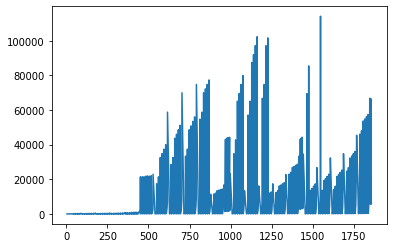

In [126]:
estimated_time_and_bound = fc_data.apply(lambda x: estimate_runtime(x['batch_size'], x['M'], x['N'], x['K'], clf, use_th_peak=True), axis=1, result_type="expand")
estimated_time_and_bound.columns = ['time', 'bound', 'dram_traffic']
estimated_time_and_bound['actual_time'] = fc_data['kernel_runtime']
estimated_time_and_bound['kernel_name'] = fc_data['kernel_name']
error = err(estimated_time_and_bound['time'], estimated_time_and_bound['actual_time'])
histogram(error, bins=[-5.0, -4.0, -3.0, -2.0, -1.5, -1.0, -0.95, -0.9, -0.8, -0.6, -0.5, -0.4, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9, 0.95, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 10.0, 20.0, 100.0, 1000.0, 10000.0])
print("GMAE: {:.2f}%, mean: {:.2f}%, std: {:.2f}%".format(gmae(error) * 100.0, error.mean() * 100.0, error.std() * 100.0))
plt.figure()
plt.plot(estimated_time_and_bound['time'])

In [117]:
# Compare measured DRAM time with calculated DRAM time
e = err(((fc_data['dram_read_transactions'] + fc_data['dram_write_transactions']) * 32), estimated_time_and_bound['dram_traffic'])
his = histogram(e, bins=[-5.0, -4.0, -3.0, -2.0, -1.5, -1.0, -0.95, -0.9, -0.8, -0.6, -0.5, -0.4, -0.3, -0.25, -0.2, -0.15, -0.1, -0.05, 0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9, 0.95, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, 10.0, 20.0, 100.0, 1000.0, 10000.0])

-500% - -400%: 0.00%
-400% - -300%: 0.00%
-300% - -200%: 0.00%
-200% - -150%: 0.00%
-150% - -100%: 0.00%
-100% - -95%: 5.04%
-95% - -90%: 0.36%
-90% - -80%: 1.09%
-80% - -60%: 1.46%
-60% - -50%: 0.97%
-50% - -40%: 1.88%
-40% - -30%: 1.88%
-30% - -25%: 0.79%
-25% - -20%: 1.03%
-20% - -15%: 2.13%
-15% - -10%: 1.70%
-10% - -5%: 2.79%
-5% - 0%: 4.07%
0% - 5%: 3.70%
5% - 10%: 3.70%
10% - 15%: 2.06%
15% - 20%: 2.25%
20% - 25%: 2.06%
25% - 30%: 2.06%
30% - 40%: 4.01%
40% - 50%: 3.89%
50% - 60%: 2.55%
60% - 80%: 9.05%
80% - 90%: 5.28%
90% - 95%: 2.49%
95% - 100%: 1.82%
100% - 150%: 10.75%
150% - 200%: 5.10%
200% - 300%: 4.74%
300% - 400%: 2.55%
400% - 500%: 0.73%
500% - 1000%: 2.79%
1000% - 2000%: 2.49%
2000% - 10000%: 0.73%
10000% - 100000%: 0.00%
100000% - 1000000%: 0.00%
